Added Shape: vertical_range_dist_db -> VerticalRangeDistributionDBShape({'time_min': 0.4727888747185798, 'time_max': 3.2770036401231404, 'strength_dB': 20.0, 'distribution': 'gaussian', 'distribution_params': {'sigma': 1.9543714173317397}})
Added Shape: horizontal_line -> HorizontalLineDBShape({'center_freq': 6862.839968775373, 'strength_dB': 20.0, 'thickness': 1})
Added Shape: horizontal_range_dist_db -> HorizontalRangeDistributionDBShape({'freq_min': 78.02024814068676, 'freq_max': 878.3535707468072, 'strength_dB': 20.0, 'distribution': 'gaussian', 'distribution_params': {'sigma': 1092.1556408269912}})
Added Shape: horizontal_range_dist_db -> HorizontalRangeDistributionDBShape({'freq_min': 3825.6203877968665, 'freq_max': 4625.5257833581445, 'strength_dB': 20.0, 'distribution': 'gaussian', 'distribution_params': {'sigma': 1030.8829673166574}})
Added Shape: vertical_line -> VerticalLineDBShape({'center_time': 3.7108303545415873, 'strength_dB': 20.0, 'thickness': 1})
Added Pattern: n_lin

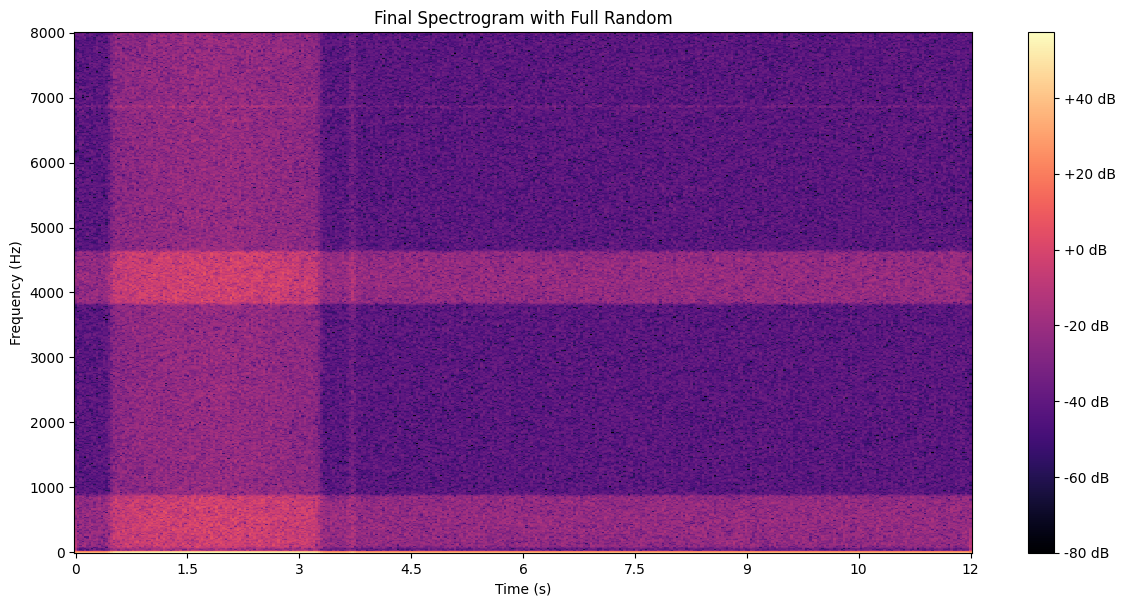

In [132]:
import random
import numpy as np
import matplotlib.pyplot as plt
import librosa
import librosa.display
from abc import ABC, abstractmethod
from scipy.ndimage import gaussian_filter

# =========================================================
# 1) 스펙트로그램 처리 (SpectrogramModifier)
# =========================================================
class SpectrogramModifier:
    def __init__(self, sample_rate=16000, n_fft=1024, hop_length=512,
                 noise_strength=0.1, noise_type='normal', noise_params=None):
        self.sample_rate = sample_rate
        self.n_fft = n_fft
        self.hop_length = hop_length
        self.noise_strength = noise_strength
        self.noise_type = noise_type
        self.noise_params = noise_params if noise_params else {}
        self.signal = None
        self.signal_with_noise = None
        self.S_db = None

    def _generate_normal_noise(self, length, params):
        mean = params.get('mean', 0.0)
        std = params.get('std', 1.0)
        return np.random.normal(mean, std, length)

    def _generate_uniform_noise(self, length, params):
        low = params.get('low', -1.0)
        high = params.get('high', 1.0)
        return np.random.uniform(low, high, length)

    def _generate_perlin_noise(self, length, params):
        def fade(t):
            return 6 * t**5 - 15 * t**4 + 10 * t**3

        seed = params.get('seed', 42)
        np.random.seed(seed)
        perm = np.arange(256)
        np.random.shuffle(perm)
        perm = np.stack([perm, perm]).flatten()
        scale = params.get('scale', 50.0)
        xs = np.linspace(0, length / scale, length)
        xi = np.floor(xs).astype(int)
        xf = xs - xi
        xi = xi % 256
        left_hash = perm[xi]
        right_hash = perm[xi + 1]
        u = fade(xf)
        left_grad = ((left_hash & 1) * 2 - 1) * xf
        right_grad = ((right_hash & 1) * 2 - 1) * (xf - 1)
        noise = (1 - u) * left_grad + u * right_grad
        noise = noise / np.max(np.abs(noise))
        return noise

    def generate_noise(self, signal):
        length = len(signal)
        nt = self.noise_type
        p = self.noise_params
        if nt == 'normal':
            noise = self._generate_normal_noise(length, p)
        elif nt == 'uniform':
            noise = self._generate_uniform_noise(length, p)
        elif nt == 'perlin':
            noise = self._generate_perlin_noise(length, p)
        else:
            noise = np.zeros_like(signal)
        return signal + noise * self.noise_strength

    def compute_spectrogram(self, signal):
        self.signal = signal
        self.signal_with_noise = self.generate_noise(signal)
        S = np.abs(
            librosa.stft(
                self.signal_with_noise,
                n_fft=self.n_fft,
                hop_length=self.hop_length,
                window='hann'
            )
        )
        self.S_db = librosa.amplitude_to_db(S, ref=np.max)
        return self.S_db

    def _get_freqs(self):
        return np.linspace(0, self.sample_rate / 2, self.S_db.shape[0])

    def _get_times(self):
        return librosa.frames_to_time(
            np.arange(self.S_db.shape[1]),
            sr=self.sample_rate,
            hop_length=self.hop_length
        )

    def apply_dB_mask(self, dB_mask):
        self.S_db += dB_mask

    def plot_spectrogram(self, show_labels=True, colormap='magma', title='Spectrogram'):
        if self.S_db is None:
            raise ValueError("compute_spectrogram() 먼저 호출")
        fig, ax = plt.subplots(figsize=(12, 6))
        img = librosa.display.specshow(
            self.S_db,
            sr=self.sample_rate,
            hop_length=self.hop_length,
            x_axis='time',
            y_axis='linear',
            ax=ax,
            cmap=colormap
        )
        if show_labels:
            ax.set_xlabel('Time (s)')
            ax.set_ylabel('Frequency (Hz)')
            ax.set_title(title)
            fig.colorbar(img, ax=ax, format="%+2.0f dB")
        else:
            ax.axis('off')
            plt.subplots_adjust(left=0, right=1, top=1, bottom=0)
        plt.tight_layout(pad=0.5)
        return fig, ax


# =========================================================
# 2) DBShape (추상 클래스로 유지)
# =========================================================
class DBShape(ABC):
    @abstractmethod
    def create_mask(self, spectro_shape, spectro_mod):
        pass


# =========================================================
# 3) Shape(도형) 계층
# =========================================================
class BaseShape(DBShape):
    def __init__(self):
        pass

    @abstractmethod
    def generate_shape_mask(self, spectro_shape, spectro_mod):
        pass

    def create_mask(self, spectro_shape, spectro_mod):
        return self.generate_shape_mask(spectro_shape, spectro_mod)

    def __repr__(self):
        # 클래스 이름과 모든 속성 출력
        return f"{self.__class__.__name__}({self.__dict__})"


class CircleDBShape(BaseShape):
    def __init__(self, center_freq, center_time, radius_freq, radius_time, strength_dB):
        super().__init__()
        self.center_freq = center_freq
        self.center_time = center_time
        self.radius_freq = radius_freq
        self.radius_time = radius_time
        self.strength_dB = strength_dB

    def generate_shape_mask(self, spectro_shape, spectro_mod):
        freqs = spectro_mod._get_freqs()
        times = spectro_mod._get_times()
        ff, tt = np.meshgrid(freqs, times, indexing='ij')
        dist = (
            (ff - self.center_freq) ** 2 / (self.radius_freq ** 2)
            + (tt - self.center_time) ** 2 / (self.radius_time ** 2)
        )
        circle = (dist <= 1).astype(float)
        return circle * self.strength_dB


class TrapezoidDBShape(BaseShape):
    def __init__(self, freq_min, freq_max, time_min, time_max,
                 slope_freq, slope_time, strength_dB):
        super().__init__()
        self.freq_min = freq_min
        self.freq_max = freq_max
        self.time_min = time_min
        self.time_max = time_max
        self.slope_freq = slope_freq
        self.slope_time = slope_time
        self.strength_dB = strength_dB

    def generate_shape_mask(self, spectro_shape, spectro_mod):
        mask = np.zeros(spectro_shape)
        freqs = spectro_mod._get_freqs()
        times = spectro_mod._get_times()

        freq_mask = (freqs >= self.freq_min) & (freqs <= self.freq_max)
        time_mask = (times >= self.time_min) & (times <= self.time_max)
        f_inds = np.where(freq_mask)[0]
        t_inds = np.where(time_mask)[0]

        if len(f_inds) == 0 or len(t_inds) == 0:
            return mask

        f_dist = (freqs[f_inds] - self.freq_min) / (self.freq_max - self.freq_min)
        t_dist = (times[t_inds] - self.time_min) / (self.time_max - self.time_min)

        for i, fi in enumerate(f_inds):
            for j, ti in enumerate(t_inds):
                val = self.strength_dB
                val *= (1 - abs(f_dist[i] - 0.5) * 2 * self.slope_freq)
                val *= (1 - abs(t_dist[j] - 0.5) * 2 * self.slope_time)
                mask[fi, ti] += val
        return mask


class SpikeDBShape(BaseShape):
    def __init__(self, center_freq, center_time,
                 radius_freq, radius_time,
                 strength_dB,
                 rotate=0.0):
        super().__init__()
        self.center_freq = center_freq
        self.center_time = center_time
        self.radius_freq = radius_freq
        self.radius_time = radius_time
        self.strength_dB = strength_dB
        self.rotate_deg = rotate

    def generate_shape_mask(self, spectro_shape, spectro_mod):
        freqs = spectro_mod._get_freqs()
        times = spectro_mod._get_times()
        ff, tt = np.meshgrid(freqs, times, indexing='ij')

        f_shift = ff - self.center_freq
        t_shift = tt - self.center_time

        angle_rad = np.deg2rad(self.rotate_deg)
        cos_a = np.cos(angle_rad)
        sin_a = np.sin(angle_rad)

        f_rot = f_shift * cos_a - t_shift * sin_a
        t_rot = f_shift * sin_a + t_shift * cos_a

        dist = np.sqrt((f_rot**2)/(self.radius_freq**2) +
                       (t_rot**2)/(self.radius_time**2))
        spike = np.exp(-dist**2) * self.strength_dB  # 가우시안 분포로 변경
        return spike


class PillarDBShape(BaseShape):
    def __init__(self, freq_min, freq_max, strength_dB):
        super().__init__()
        self.freq_min = freq_min
        self.freq_max = freq_max
        self.strength_dB = strength_dB

    def generate_shape_mask(self, spectro_shape, spectro_mod):
        mask = np.zeros(spectro_shape)
        freqs = spectro_mod._get_freqs()
        freq_indices = np.where((freqs >= self.freq_min) & (freqs <= self.freq_max))[0]
        if len(freq_indices) == 0:
            return mask
        mask[freq_indices, :] += self.strength_dB
        return mask


class RectangleDBShape(BaseShape):
    def __init__(self, freq_min, freq_max, time_min, time_max, strength_dB):
        super().__init__()
        self.freq_min = freq_min
        self.freq_max = freq_max
        self.time_min = time_min
        self.time_max = time_max
        self.strength_dB = strength_dB

    def generate_shape_mask(self, spectro_shape, spectro_mod):
        mask = np.zeros(spectro_shape)
        freqs = spectro_mod._get_freqs()
        times = spectro_mod._get_times()
        freq_indices = np.where((freqs >= self.freq_min) & (freqs <= self.freq_max))[0]
        time_indices = np.where((times >= self.time_min) & (times <= self.time_max))[0]
        if len(freq_indices) == 0 or len(time_indices) == 0:
            return mask
        mask[np.ix_(freq_indices, time_indices)] += self.strength_dB
        return mask


class EllipseDBShape(BaseShape):
    def __init__(self, center_freq, center_time,
                 radius_freq, radius_time,
                 strength_dB):
        super().__init__()
        self.center_freq = center_freq
        self.center_time = center_time
        self.radius_freq = radius_freq
        self.radius_time = radius_time
        self.strength_dB = strength_dB

    def generate_shape_mask(self, spectro_shape, spectro_mod):
        freqs = spectro_mod._get_freqs()
        times = spectro_mod._get_times()
        ff, tt = np.meshgrid(freqs, times, indexing='ij')
        dist = (
            (ff - self.center_freq) ** 2 / (self.radius_freq ** 2)
            + (tt - self.center_time) ** 2 / (self.radius_time ** 2)
        )
        ellipse = (dist <= 1).astype(float)
        return ellipse * self.strength_dB


class HorizontalSpikeDBShape(BaseShape):
    def __init__(self, center_freq, center_time,
                 radius_freq, radius_time,
                 strength_dB):
        super().__init__()
        self.center_freq = center_freq
        self.center_time = center_time
        self.radius_freq = radius_freq  # 전달된 radius_freq 사용
        self.radius_time = radius_time
        self.strength_dB = strength_dB

    def generate_shape_mask(self, spectro_shape, spectro_mod):
        # 수평 스파이크: 주파수 방향으로 좁게 설정
        spike_shape = SpikeDBShape(
            center_freq=self.center_freq,
            center_time=self.center_time,
            radius_freq=self.radius_freq,  # 전달된 radius_freq 사용
            radius_time=self.radius_time,
            strength_dB=self.strength_dB,
            rotate=0.0  # 변경 금지
        )
        return spike_shape.generate_shape_mask(spectro_shape, spectro_mod)


class VerticalSpikeDBShape(BaseShape):
    def __init__(self, center_freq, center_time,
                 radius_freq, radius_time,
                 strength_dB):
        super().__init__()
        self.center_freq = center_freq
        self.center_time = center_time
        self.radius_freq = radius_freq
        self.radius_time = radius_time 
        self.strength_dB = strength_dB

    def generate_shape_mask(self, spectro_shape, spectro_mod):
        spike_shape = SpikeDBShape(
            center_freq=self.center_freq,
            center_time=self.center_time,
            radius_freq=self.radius_freq,
            radius_time=self.radius_time, 
            strength_dB=self.strength_dB,
            rotate=0.0  # 변경 금지
        )
        return spike_shape.generate_shape_mask(spectro_shape, spectro_mod)


class HorizontalRangeDistributionDBShape(BaseShape):
    def __init__(self, freq_min, freq_max, strength_dB,
                 distribution='gaussian', distribution_params=None):
        super().__init__()
        self.freq_min = freq_min
        self.freq_max = freq_max
        self.strength_dB = strength_dB
        self.distribution = distribution
        self.distribution_params = distribution_params if distribution_params else {}

    def _get_distribution(self, values):
        # Handle different distribution types
        sigma = self.distribution_params.get('sigma', 1000)
        center = (values.min() + values.max()) / 2
        dist = np.exp(-0.5 * ((values - center) / sigma) ** 2)
        if dist.max() != 0:
            dist /= dist.max()
        return dist

    def generate_shape_mask(self, spectro_shape, spectro_mod):
        mask = np.zeros(spectro_shape)
        freqs = spectro_mod._get_freqs()
        freq_indices = np.where((freqs >= self.freq_min) & (freqs <= self.freq_max))[0]
        
        # Check if any frequencies are within the specified range
        if len(freq_indices) == 0:
            return mask

        freq_values = freqs[freq_indices]
        dist_values = self._get_distribution(freq_values)
        
        # Apply the distribution to the mask
        for i, fi in enumerate(freq_indices):
            mask[fi, :] += self.strength_dB * dist_values[i]
        
        return mask


class VerticalRangeDistributionDBShape(BaseShape):
    def __init__(self, time_min, time_max, strength_dB,
                 distribution='gaussian', distribution_params=None):
        super().__init__()
        self.time_min = time_min
        self.time_max = time_max
        self.strength_dB = strength_dB
        self.distribution = distribution
        self.distribution_params = distribution_params if distribution_params else {}

    def _get_distribution(self, values):
        sigma = self.distribution_params.get('sigma', 0.5)
        center = (values.min() + values.max()) / 2
        dist = np.exp(-0.5 * ((values - center) / sigma) ** 2)
        dist /= dist.max()
        return dist

    def generate_shape_mask(self, spectro_shape, spectro_mod):
        mask = np.zeros(spectro_shape)
        times = spectro_mod._get_times()
        time_indices = np.where((times >= self.time_min) & (times <= self.time_max))[0]
        if len(time_indices) == 0:
            return mask

        time_vals = times[time_indices]
        dist_values = self._get_distribution(time_vals)
        for i, ti in enumerate(time_indices):
            mask[:, ti] += self.strength_dB * dist_values[i]
        return mask


class HillDBShape(BaseShape):
    def __init__(self, freq_center, time_center,
                 freq_width, time_width,
                 strength_dB):
        super().__init__()
        self.freq_center = freq_center
        self.time_center = time_center
        self.freq_width = freq_width
        self.time_width = time_width
        self.strength_dB = strength_dB

    def generate_shape_mask(self, spectro_shape, spectro_mod):
        freqs = spectro_mod._get_freqs()
        times = spectro_mod._get_times()
        ff, tt = np.meshgrid(freqs, times, indexing='ij')
        dist = np.sqrt(
            ((ff - self.freq_center) ** 2) / (self.freq_width ** 2)
            + ((tt - self.time_center) ** 2) / (self.time_width ** 2)
        )
        hill = (1 - dist)
        hill[hill < 0] = 0
        return hill * self.strength_dB


class FogDBShape(BaseShape):
    def __init__(self, strength_dB, coverage=1.0):
        super().__init__()
        self.strength_dB = strength_dB
        self.coverage = coverage

    def generate_shape_mask(self, spectro_shape, spectro_mod):
        random_map = np.random.uniform(0, 1, spectro_shape)
        fog = (random_map < self.coverage).astype(float)
        fog *= self.strength_dB * (np.random.randn(*spectro_shape) * 0.1)
        return fog


class PolygonDBShape(BaseShape):
    def __init__(self, vertices, strength_dB):
        super().__init__()
        self.vertices = vertices
        self.strength_dB = strength_dB

    def generate_shape_mask(self, spectro_shape, spectro_mod):
        from matplotlib.path import Path
        freqs = spectro_mod._get_freqs()
        times = spectro_mod._get_times()
        ff, tt = np.meshgrid(freqs, times, indexing='ij')

        path = Path(self.vertices)
        points = np.vstack((ff.ravel(), tt.ravel())).T
        inside = path.contains_points(points).reshape(ff.shape)
        mask = np.zeros(spectro_shape)
        mask[inside] = self.strength_dB
        return mask


class WavePatternDBShape(BaseShape):
    def __init__(self, axis='time', frequency=1.0, strength_dB=5.0):
        super().__init__()
        self.axis = axis
        self.frequency = frequency
        self.strength_dB = strength_dB

    def generate_shape_mask(self, spectro_shape, spectro_mod):
        freqs = spectro_mod._get_freqs()
        times = spectro_mod._get_times()
        mask = np.zeros(spectro_shape)
        if self.axis == 'time':
            wave = np.sin(2 * np.pi * self.frequency * times)
            mask += wave[np.newaxis, :] * self.strength_dB
        else:
            wave = np.sin(2 * np.pi * self.frequency * freqs)
            mask += wave[:, np.newaxis] * self.strength_dB
        return mask


class RealWorldNoiseDBShape(BaseShape):
    def __init__(self, audio_path, freq_min, freq_max,
                 time_min, time_max, strength_dB=0):
        super().__init__()
        self.audio_path = audio_path
        self.freq_min = freq_min
        self.freq_max = freq_max
        self.time_min = time_min
        self.time_max = time_max
        self.strength_dB = strength_dB

    def generate_shape_mask(self, spectro_shape, spectro_mod):
        y, sr = librosa.load(self.audio_path, sr=spectro_mod.sample_rate)
        S = np.abs(librosa.stft(y, n_fft=spectro_mod.n_fft, hop_length=spectro_mod.hop_length))
        S_db = librosa.amplitude_to_db(S, ref=np.max)

        freqs = spectro_mod._get_freqs()
        times = spectro_mod._get_times()
        freq_indices = np.where((freqs >= self.freq_min) & (freqs <= self.freq_max))[0]
        time_indices = np.where((times >= self.time_min) & (times <= self.time_max))[0]

        if len(freq_indices) == 0 or len(time_indices) == 0:
            return np.zeros(spectro_shape)

        f_cut = min(len(freq_indices), S_db.shape[0])
        t_cut = min(len(time_indices), S_db.shape[1])

        mask = np.zeros(spectro_shape)
        mask[freq_indices[:f_cut], time_indices[:t_cut]] += (S_db[:f_cut, :t_cut]
                                                             + self.strength_dB)
        return mask


class HorizontalLineDBShape(BaseShape):
    def __init__(self, center_freq, strength_dB, thickness=2):
        super().__init__()
        self.center_freq = center_freq
        self.strength_dB = strength_dB
        self.thickness = thickness

    def generate_shape_mask(self, spectro_shape, spectro_mod):
        mask = np.zeros(spectro_shape)
        freqs = spectro_mod._get_freqs()
        freq_idx = np.argmin(np.abs(freqs - self.center_freq))
        start_idx = max(freq_idx - self.thickness // 2, 0)
        end_idx = min(freq_idx + self.thickness // 2 + 1, spectro_shape[0])
        mask[start_idx:end_idx, :] += self.strength_dB
        return mask


class VerticalLineDBShape(BaseShape):
    def __init__(self, center_time, strength_dB, thickness=2):
        super().__init__()
        self.center_time = center_time
        self.strength_dB = strength_dB
        self.thickness = thickness

    def generate_shape_mask(self, spectro_shape, spectro_mod):
        mask = np.zeros(spectro_shape)
        times = spectro_mod._get_times()
        time_idx = np.argmin(np.abs(times - self.center_time))
        start_idx = max(time_idx - self.thickness // 2, 0)
        end_idx = min(time_idx + self.thickness // 2 + 1, spectro_shape[1])
        mask[:, start_idx:end_idx] += self.strength_dB
        return mask


# =========================================================
# 4) Pattern(패턴) 계층
# =========================================================
class Pattern(ABC):
    @abstractmethod
    def create_mask(self, spectro_shape, spectro_mod, shape_factory):
        pass

    def __repr__(self):
        return f"{self.__class__.__name__}({self.__dict__})"


class LinearPattern(Pattern):
    def __init__(self, shape_name, shape_params,
                 direction='time', repeat=5, spacing=1.0):
        self.shape_name = shape_name
        self.shape_params = shape_params
        self.direction = direction
        self.repeat = repeat
        self.spacing = spacing

    def create_mask(self, spectro_shape, spectro_mod, shape_factory):
        mask = np.zeros(spectro_shape)
        for i in range(self.repeat):
            offset = i * self.spacing
            params = self.shape_params.copy()
            if self.direction == 'time' and 'center_time' in params:
                params['center_time'] += offset
            elif self.direction == 'freq' and 'center_freq' in params:
                params['center_freq'] += offset

            shape_obj = shape_factory.create(self.shape_name, **params)
            if shape_obj is not None:
                mask += shape_obj.create_mask(spectro_shape, spectro_mod)
        return mask


class RandomPattern(Pattern):
    def __init__(self, shape_name, shape_params,
                 n=10, freq_range=None, time_range=None):
        self.shape_name = shape_name
        self.shape_params = shape_params
        self.n = n
        self.freq_range = freq_range if freq_range else (0, 8000)
        self.time_range = time_range if time_range else (0, 10)

    def create_mask(self, spectro_shape, spectro_mod, shape_factory):
        mask = np.zeros(spectro_shape)
        for _ in range(self.n):
            params = self.shape_params.copy()
            if 'center_freq' in params:
                params['center_freq'] = np.random.uniform(*self.freq_range)
            if 'center_time' in params:
                params['center_time'] = np.random.uniform(*self.time_range)

            shape_obj = shape_factory.create(self.shape_name, **params)
            if shape_obj:
                mask += shape_obj.create_mask(spectro_shape, spectro_mod)
        return mask


class NLinearRepeatTSleepPattern(Pattern):
    def __init__(self, shape_name, shape_params,
                 repeat=3, repeat_time=0.5,
                 sleep_time=5.0, start_time=0.0,
                 direction='time'):  # direction 추가
        self.shape_name = shape_name
        self.shape_params = shape_params
        self.repeat = repeat
        self.repeat_time = repeat_time
        self.sleep_time = sleep_time
        self.start_time = start_time
        self.direction = direction  # direction 저장

    def create_mask(self, spectro_shape, spectro_mod, shape_factory):
        mask = np.zeros(spectro_shape)
        if self.direction == 'time':
            current_time = self.start_time
        elif self.direction == 'freq':
            current_freq = self.start_time
        else:
            raise ValueError("Invalid direction. Use 'time' or 'freq'.")

        for _ in range(self.repeat):
            params = self.shape_params.copy()
            if self.direction == 'time' and 'center_time' in params:
                params['center_time'] = current_time
            elif self.direction == 'freq' and 'center_freq' in params:
                params['center_freq'] = current_freq

            shape_obj = shape_factory.create(self.shape_name, **params)
            if shape_obj:
                mask += shape_obj.create_mask(spectro_shape, spectro_mod)
            if self.direction == 'time':
                current_time += self.repeat_time
            elif self.direction == 'freq':
                current_freq += self.repeat_time

        # Sleep time is not applied here as per the user's requirement
        # If needed, implement logic to skip sleep_time

        return mask


class ConvexPattern(Pattern):
    def __init__(self, shape_name, shape_params,
                 freq_min, freq_max, time_min, time_max,
                 n=10):
        self.shape_name = shape_name
        self.shape_params = shape_params
        self.freq_min = freq_min
        self.freq_max = freq_max
        self.time_min = time_min
        self.time_max = time_max
        self.n = n

    def create_mask(self, spectro_shape, spectro_mod, shape_factory):
        mask = np.zeros(spectro_shape)
        freqs = np.linspace(self.freq_min, self.freq_max, self.n)
        times = np.linspace(self.time_min, self.time_max, self.n)
        for i in range(self.n):
            params = self.shape_params.copy()
            if 'center_freq' in params:
                params['center_freq'] = freqs[i]
            if 'center_time' in params:
                params['center_time'] = times[i]

            shape_obj = shape_factory.create(self.shape_name, **params)
            if shape_obj:
                mask += shape_obj.create_mask(spectro_shape, spectro_mod)
        return mask


class FunctionPattern(Pattern):
    def __init__(self, func):
        self.func = func

    def create_mask(self, spectro_shape, spectro_mod, shape_factory):
        freqs = spectro_mod._get_freqs()
        times = spectro_mod._get_times()
        ff, tt = np.meshgrid(freqs, times, indexing='ij')
        return self.func(ff, tt)


# =========================================================
# 5) 팩토리 (ShapeFactory, PatternFactory)
# =========================================================
class ShapeFactory:
    def create(self, shape_name, **kwargs):
        shape_name = shape_name.lower()
        if shape_name == "circle":
            return CircleDBShape(
                center_freq=kwargs['center_freq'],
                center_time=kwargs['center_time'],
                radius_freq=kwargs['radius_freq'],
                radius_time=kwargs['radius_time'],
                strength_dB=kwargs['strength_dB']
            )
        elif shape_name == "trapezoid":
            return TrapezoidDBShape(
                freq_min=kwargs['freq_min'],
                freq_max=kwargs['freq_max'],
                time_min=kwargs['time_min'],
                time_max=kwargs['time_max'],
                slope_freq=kwargs['slope_freq'],
                slope_time=kwargs['slope_time'],
                strength_dB=kwargs['strength_dB']
            )
        elif shape_name == "rectangle":
            return RectangleDBShape(
                freq_min=kwargs['freq_min'],
                freq_max=kwargs['freq_max'],
                time_min=kwargs['time_min'],
                time_max=kwargs['time_max'],
                strength_dB=kwargs['strength_dB']
            )
        elif shape_name == "ellipse":
            return EllipseDBShape(
                center_freq=kwargs['center_freq'],
                center_time=kwargs['center_time'],
                radius_freq=kwargs['radius_freq'],
                radius_time=kwargs['radius_time'],
                strength_dB=kwargs['strength_dB']
            )
        elif shape_name == "fog":
            return FogDBShape(
                strength_dB=kwargs['strength_dB'],
                coverage=kwargs.get('coverage', 1.0)
            )
        elif shape_name == "polygon":
            return PolygonDBShape(
                vertices=kwargs['vertices'],
                strength_dB=kwargs['strength_dB']
            )
        elif shape_name == "wave_pattern":
            return WavePatternDBShape(
                axis=kwargs.get('axis', 'time'),
                frequency=kwargs['frequency'],
                strength_dB=kwargs['strength_dB']
            )
        elif shape_name == "real_world_noise":
            return RealWorldNoiseDBShape(
                audio_path=kwargs['audio_path'],
                freq_min=kwargs['freq_min'],
                freq_max=kwargs['freq_max'],
                time_min=kwargs['time_min'],
                time_max=kwargs['time_max'],
                strength_dB=kwargs['strength_dB']
            )
        elif shape_name == "horizontal_spike":
            return HorizontalSpikeDBShape(
                center_freq=kwargs['center_freq'],
                center_time=kwargs['center_time'],
                radius_freq=kwargs['radius_freq'],
                radius_time=kwargs['radius_time'],
                strength_dB=kwargs['strength_dB']
            )
        elif shape_name == "vertical_spike":
            return VerticalSpikeDBShape(
                center_freq=kwargs['center_freq'],
                center_time=kwargs['center_time'],
                radius_freq=kwargs['radius_freq'],
                radius_time=kwargs['radius_time'],
                strength_dB=kwargs['strength_dB']
            )
        elif shape_name == "hill":
            return HillDBShape(
                freq_center=kwargs['freq_center'],
                time_center=kwargs['time_center'],
                freq_width=kwargs['freq_width'],
                time_width=kwargs['time_width'],
                strength_dB=kwargs['strength_dB']
            )
        elif shape_name == "pillar":
            return PillarDBShape(
                freq_min=kwargs['freq_min'],
                freq_max=kwargs['freq_max'],
                strength_dB=kwargs['strength_dB']
            )
        elif shape_name == "horizontal_line":
            return HorizontalLineDBShape(
                center_freq=kwargs['center_freq'],
                strength_dB=kwargs['strength_dB'],
                thickness=kwargs.get('thickness', 1)
            )
        elif shape_name == "vertical_line":
            return VerticalLineDBShape(
                center_time=kwargs['center_time'],
                strength_dB=kwargs['strength_dB'],
                thickness=kwargs.get('thickness', 1)
            )
        elif shape_name == "horizontal_range_dist_db":
            return HorizontalRangeDistributionDBShape(
                freq_min=kwargs['freq_min'],
                freq_max=kwargs['freq_max'],
                strength_dB=kwargs['strength_dB'],
                distribution=kwargs.get('distribution', 'gaussian'),
                distribution_params=kwargs.get('distribution_params', {})
            )
        elif shape_name == "vertical_range_dist_db":
            return VerticalRangeDistributionDBShape(
                time_min=kwargs['time_min'],
                time_max=kwargs['time_max'],
                strength_dB=kwargs['strength_dB'],
                distribution=kwargs.get('distribution', 'gaussian'),
                distribution_params=kwargs.get('distribution_params', {})
            )
        else:
            raise ValueError(f"Unknown shape name: {shape_name}")


class PatternFactory:
    def create(self, pattern_name, params):
        pattern_name = pattern_name.lower()
        if pattern_name == "linear":
            return LinearPattern(
                params['shape_name'],
                params['shape_params'],
                params.get('direction', 'time'),
                params.get('repeat', 5),
                params.get('spacing', 1.0)
            )
        elif pattern_name == "random":
            return RandomPattern(
                params['shape_name'],
                params['shape_params'],
                params.get('n', 10),
                params.get('freq_range', (0, 16000)),
                params.get('time_range', (0.0, 12.0))
            )
        elif pattern_name == "n_linear_repeat_t_sleep":
            return NLinearRepeatTSleepPattern(
                shape_name=params['shape_name'],
                shape_params=params['shape_params'],
                repeat=params.get('repeat', 3),
                repeat_time=params.get('repeat_time', 0.5),
                sleep_time=params.get('sleep_time', 5.0),
                start_time=params.get('start_time', 0.0),
                direction=params.get('direction', 'time')  # direction 전달
            )
        elif pattern_name == "convex":
            return ConvexPattern(
                params['shape_name'],
                params['shape_params'],
                params['freq_min'],
                params['freq_max'],
                params['time_min'],
                params['time_max'],
                params.get('n', 10)
            )
        elif pattern_name == "function":
            return FunctionPattern(params['func'])
        else:
            return None


# =========================================================
# 6) NoisePipeline (전역 블러 옵션 포함)
# =========================================================
class NoisePipeline:
    def __init__(self, spectro_mod, apply_blur=False, blur_sigma=1.0):
        self.spectro_mod = spectro_mod
        self.shape_factory = ShapeFactory()
        self.pattern_factory = PatternFactory()
        self.shapes = []
        self.patterns = []
        self.apply_blur = apply_blur
        self.blur_sigma = blur_sigma

    def add_shape(self, shape):
        self.shapes.append(shape)
        return self

    def add_pattern(self, pattern):
        if pattern is not None:
            self.patterns.append(pattern)
        return self

    def generate(self, signal):
        spec = self.spectro_mod.compute_spectrogram(signal)
        total_mask = np.zeros_like(spec)

        for shape in self.shapes:
            shape_mask = shape.create_mask(spec.shape, self.spectro_mod)
            total_mask += shape_mask

        for pattern in self.patterns:
            pattern_mask = pattern.create_mask(
                spec.shape, self.spectro_mod, self.shape_factory
            )
            total_mask += pattern_mask

        if self.apply_blur and self.blur_sigma > 0:
            total_mask = gaussian_filter(total_mask, sigma=self.blur_sigma)

        self.spectro_mod.apply_dB_mask(total_mask)
        return self.spectro_mod.S_db


# =========================================================
# 7) "가중치 기반" 아이템 선택 함수
# =========================================================
def pick_item_from_ratio(ratio_dict):
    items = list(ratio_dict.keys())
    weights = list(ratio_dict.values())
    total = sum(weights)
    if total == 0:
        raise ValueError("Total weight cannot be zero.")
    r = random.uniform(0, total)
    s = 0
    for item, w in zip(items, weights):
        s += w
        if r <= s:
            return item
    return items[-1]


# =========================================================
# 8) "모든 매개변수 랜덤" 버전 generate_shape_params
# =========================================================
def generate_shape_params(shape_name, duration, sr,
                         freq_min=20, time_min=0.0,
                         min_float_value=0.001, alpha=1.0, 
                         max_db_power=20, min_db_power=10):
    """
    Generates all parameters randomly based on the shape_name.
    Clamps time and frequency values within their specified boundaries.
    """
    params = {
        "strength_dB": random.uniform(min_db_power, max_db_power)
    }

    # Generate frequency bounds
    random_freq_min = random.uniform(freq_min, sr)
    random_freq_max = random.uniform(freq_min, sr)
    if random_freq_min > random_freq_max:
        random_freq_min, random_freq_max = random_freq_max, random_freq_min

    # Generate time bounds
    random_time_min = random.uniform(time_min, duration)
    random_time_max = random.uniform(time_min, duration)
    if random_time_min > random_time_max:
        random_time_min, random_time_max = random_time_max, random_time_min

    # Generate range thresholds
    random_time_range_threshold = random.normalvariate((time_min + duration)/2, 1) * 0.1
    random_freq_range_threshold = random.normalvariate((freq_min + sr)/2, 1) * 0.1

    # Define a helper function to clamp values
    def clamp(value, min_value, max_value):
        return max(min_value, min(value, max_value))

    # Shape-specific parameter generation
    if shape_name == "horizontal_spike":
        params.update({
            "center_freq": random.uniform(random_freq_min, random_freq_max),
            "center_time": random.uniform(random_time_min, random_time_max),
            "radius_freq": clamp(random.uniform(15.0, 30.0), 15.0, sr / 2),  # 최소 주파수 해상도 이상
            "radius_time": clamp(random.uniform(random_time_max*0.01, random_time_max*0.1), 0.05, duration * alpha)
        })
    elif shape_name == "vertical_spike":
        params.update({
            "center_freq": random_freq_max * 0.001,  # 수정 금지
            "center_time": random.uniform(random_time_min, random_time_max),
            "radius_freq": random.uniform(random_freq_max * 0.1 , random_freq_max),  # 수정 금지
            "radius_time": clamp(random.uniform(random_time_max*0.01, random_time_max*0.1), 0.05, duration * alpha)
        })
    elif shape_name == "trapezoid":
        params.update({
            "freq_min": clamp(random_freq_min, freq_min, sr),
            "freq_max": clamp(random_freq_max, freq_min, sr),
            "time_min": clamp(random_time_min, time_min, duration),
            "time_max": clamp(random_time_max, time_min, duration),
            "slope_freq": random.uniform(0.0, 2.0),
            "slope_time": random.uniform(0.0, 2.0)
        })
    elif shape_name == "fog":
        params.update({
            "coverage": clamp(random.uniform(0, 1), 0, 1)
        })
    elif shape_name == "hill":
        freq_center = random.uniform(random_freq_min, random_freq_max)
        center_time = random.uniform(random_time_min, random_time_max)
        freq_width = random.uniform(min_float_value, (random_freq_max - random_freq_min) * alpha)
        time_width = random.uniform(min_float_value, duration * alpha)
        
        params.update({
            "freq_center": clamp(freq_center, 0, sr),
            "time_center": clamp(center_time, 0, duration),
            "freq_width": clamp(freq_width, min_float_value, sr),
            "time_width": clamp(time_width, min_float_value, duration)
        })
    elif shape_name == "wave_pattern":
        params.update({
            "axis": random.choice(["time", "freq"]),
            "frequency": clamp(random.uniform(0.1, 10), 0.1, 10)
        })
    elif shape_name == "polygon":
        num_vertices = random.randint(3, 8)
        vertices = []
        for _ in range(num_vertices):
            f_rand = random.uniform(random_freq_min, random_freq_max)
            t_rand = random.uniform(random_time_min, random_time_max)
            f_rand = clamp(f_rand, 0, sr)
            t_rand = clamp(t_rand, 0, duration)
            vertices.append([f_rand, t_rand])
        params.update({
            "vertices": vertices
        })
    elif shape_name == "rectangle":
        params.update({
            "freq_min": clamp(random_freq_min, freq_min, sr),
            "freq_max": clamp(random_freq_max, freq_min, sr),
            "time_min": clamp(random_time_min, time_min, duration),
            "time_max": clamp(random_time_max, time_min, duration)
        })
    elif shape_name == "pillar":
        params.update({
            "freq_min": clamp(random_freq_min, freq_min, sr),
            "freq_max": clamp(random_freq_max, freq_min, sr)
        })
    elif shape_name == "horizontal_line":
        center_freq = random.uniform(random_freq_min, random_freq_max)
        params.update({
            "center_freq": clamp(center_freq, 0, sr),
            "thickness": random.randint(1, 3)
        })
    elif shape_name == "vertical_line":
        center_time = random.uniform(random_time_min, random_time_max)
        params.update({
            "center_time": clamp(center_time, 0, duration),
            "thickness": random.randint(1, 3)
        })
    elif shape_name == "horizontal_range_dist_db":
        dist_options = ["gaussian"]
        chosen_dist = random.choice(dist_options)
        freq_min_range = clamp(random_freq_min - random_freq_range_threshold, 0, sr)
        freq_max_range = clamp(random_freq_min + random_freq_range_threshold, 0, sr)
        sigma = clamp(random.uniform(1000.0 * alpha, 1100.0 * alpha), 1000.0 * alpha, 1100.0 * alpha)
        
        params.update({
            "freq_min": freq_min_range,
            "freq_max": freq_max_range,
            "distribution": chosen_dist,
            "distribution_params": {"sigma": sigma}
        })
    elif shape_name == "vertical_range_dist_db":
        dist_options = ["gaussian"]
        chosen_dist = random.choice(dist_options)
        time_min_range = clamp(random_time_min - random_time_range_threshold, 0, duration)
        time_max_range = clamp(random_time_max + random_time_range_threshold, 0, duration)
        sigma = clamp(random.uniform(1.0 * alpha, 2.0 * alpha), 1.0 * alpha, 2.0 * alpha)
        
        params.update({
            "time_min": time_min_range,
            "time_max": time_max_range,
            "distribution": chosen_dist,
            "distribution_params": {"sigma": sigma}
        })
    elif shape_name == "ellipse":
        center_freq = random.uniform(random_freq_min, random_freq_max)
        center_time = random.uniform(random_time_min, random_time_max)
        radius_freq = random.uniform(10, (random_freq_max - random_freq_min) * alpha)
        radius_time = random.uniform(min_float_value, duration * alpha)
        
        params.update({
            "center_freq": clamp(center_freq, 0, sr),
            "center_time": clamp(center_time, 0, duration),
            "radius_freq": clamp(radius_freq, 10, sr),
            "radius_time": clamp(radius_time, min_float_value, duration)
        })
    else:
        # Default handling for shapes like circle
        center_freq = random.uniform(random_freq_min, random_freq_max)
        center_time = random.uniform(random_time_min, random_time_max)
        radius_freq = random.uniform(10, (random_freq_max - random_freq_min) * alpha)
        radius_time = random.uniform(min_float_value, duration * alpha)
        
        params.update({
            "center_freq": clamp(center_freq, 0, sr),
            "center_time": clamp(center_time, 0, duration),
            "radius_freq": clamp(radius_freq, 10, sr),
            "radius_time": clamp(radius_time, min_float_value, duration)
        })

    return params


def create_random_noise_pipeline(
    spectro_mod,
    max_shapes=5,
    max_patterns=3,
    apply_blur=False,
    blur_sigma=1.0,
    duration=8.0,
    sr=16000,
    freq_min=20,
    min_float_value=0.001,
    alpha=1.0,
    ratio_shape=None,
    ratio_pattern=None,
    max_db_power=20,
    min_db_power=20,
):
    """
    ratio_shape, ratio_pattern 예시:
    ratio_shape = {"circle": 1, "rectangle": 2, "ellipse": 3, ...}
    ratio_pattern = {"linear": 1, "random": 2, "convex": 1, ...}
    """
    pipeline = NoisePipeline(spectro_mod, apply_blur=apply_blur, blur_sigma=blur_sigma)

    # ratio_shape 혹은 ratio_pattern이 None이면, 기본 후보구니 설정
    default_shapes = [
        "circle", "rectangle", "ellipse", "horizontal_spike", "vertical_spike", "fog", "pillar",
        "horizontal_line", "vertical_line",
        "horizontal_range_dist_db", "vertical_range_dist_db",
        "trapezoid", "hill", "wave_pattern", "polygon"
    ]
    default_patterns = [
        "linear", "random", "n_linear_repeat_t_sleep", "convex"
    ]

    if ratio_shape is None:
        ratio_shape = {s: 1 for s in default_shapes}
    if ratio_pattern is None:
        ratio_pattern = {p: 1 for p in default_patterns}

    shape_factory = pipeline.shape_factory
    pattern_factory = pipeline.pattern_factory

    # 1) Shape 추가
    for _ in range(random.randint(1, max_shapes)):
        shape_name = pick_item_from_ratio(ratio_shape)  # 비율에 따라 shape 선호
        try:
            shape_params = generate_shape_params(
                shape_name=shape_name, 
                duration=duration, 
                sr=sr,
                freq_min=freq_min,
                time_min=0.0,
                min_float_value=min_float_value,
                alpha=alpha,
                max_db_power=max_db_power,
                min_db_power=min_db_power
            )
            shape = shape_factory.create(shape_name, **shape_params)
            pipeline.add_shape(shape)
            print(f"Added Shape: {shape_name} -> {shape}")
        except Exception as e:
            print(f"Shape '{shape_name}' 구성 오류: {e}.")

    # 2) Pattern 추가
    for _ in range(random.randint(1, max_patterns)):
        pattern_name = pick_item_from_ratio(ratio_pattern)  # 비율에 따라 pattern 선호
        try:
            # 패턴에 사용할 shape_name 선호
            if pattern_name == "n_linear_repeat_t_sleep":
                # range 속성이 포함되지 않은 shape에 한해서 공간 지정
                possible_shape_names = [s for s in ratio_shape.keys() if not s.endswith('_range_dist_db')]
            else:
                possible_shape_names = [s for s in ratio_shape.keys() if s.startswith('horizontal_') or s.startswith('vertical_') or s.endswith('_range_dist_db')]

            if not possible_shape_names:
                print("No suitable shapes available for the selected pattern.")
                continue

            shape_name = pick_item_from_ratio({s: ratio_shape[s] for s in possible_shape_names})

            shape_params = generate_shape_params(
                shape_name=shape_name, 
                duration=duration, 
                sr=sr,
                freq_min=freq_min,
                time_min=0.0,
                min_float_value=min_float_value,
                alpha=alpha,
                max_db_power=max_db_power,
                min_db_power=min_db_power
            )

            # 반환 설정: horizontal_* or *_range_dist_db -> 'freq', vertical_* or *_range_dist_db -> 'time'
            if shape_name.startswith('horizontal_') or shape_name.endswith('_range_dist_db'):
                direction = 'freq'
            elif shape_name.startswith('vertical_') or shape_name.endswith('_range_dist_db'):
                direction = 'time'
            else:
                direction = 'time'  # 기본 반환 설정

            pattern_kwargs = {
                "shape_name": shape_name,
                "shape_params": shape_params
            }

            if pattern_name == "linear":
                pattern_kwargs.update({
                    "direction": direction,  # 반환 고정
                    "repeat": random.randint(1, max(1, int(duration * alpha / 2))),  # Adjust repeat count based on duration
                    "spacing": random.uniform(min_float_value, duration * alpha / 2)  # Adjust spacing to prevent overlaps
                })
            elif pattern_name == "random":
                pattern_kwargs.update({
                    "n": random.randint(3, int(10 * alpha)),
                    "freq_range": (freq_min, sr),
                    "time_range": (0.0, duration * alpha)
                })
            elif pattern_name == "n_linear_repeat_t_sleep":
                pattern_kwargs.update({
                    "repeat": random.randint(1, max(1, int(duration * alpha / 2))),
                    "repeat_time": random.uniform(min_float_value, duration / 10 * alpha),
                    "sleep_time": random.uniform(min_float_value, duration / 10 * alpha),
                    "start_time": random.uniform(0.0, duration * alpha),
                    "direction": direction  # 반환 고정
                })
            elif pattern_name == "convex":
                freq_a = random.uniform(freq_min, sr * alpha)
                freq_b = random.uniform(freq_min, sr * alpha)
                time_a = random.uniform(0.0, duration * alpha)
                time_b = random.uniform(0.0, duration * alpha)
                freq_min_val, freq_max_val = sorted([freq_a, freq_b])
                time_min_val, time_max_val = sorted([time_a, time_b])
                pattern_kwargs.update({
                    "freq_min": freq_min_val,
                    "freq_max": freq_max_val,
                    "time_min": time_min_val,
                    "time_max": time_max_val,
                    "n": random.randint(3, int(6 * alpha))
                })

            pattern = pattern_factory.create(pattern_name, pattern_kwargs)
            if pattern:
                pipeline.add_pattern(pattern)
                print(f"Added Pattern: {pattern_name} -> {pattern}")
        except Exception as e:
            print(f"Pattern '{pattern_name}' 구성 오류: {e}.")

    return pipeline



# ===========================
# spectrogram to audio
# ===========================
def reconstruct_with_griffinlim(spectrogram_db, n_iter=32, hop_length=512):
    amplitude = librosa.db_to_amplitude(spectrogram_db, ref=1.0)
    new_audio = librosa.griffinlim(
        amplitude,
        n_iter=n_iter,
        hop_length=hop_length,
        window='hann'
    )
    return new_audio


def reconstruct_audio_from_final_spectrogram(spectro_mod, hop_length=512):
    stft_orig = librosa.stft(
        spectro_mod.signal_with_noise,
        n_fft=spectro_mod.n_fft,
        hop_length=spectro_mod.hop_length,
        window='hann'
    )
    phase = np.angle(stft_orig)

    magnitude = librosa.db_to_amplitude(spectro_mod.S_db, ref=1.0)
    new_stft = magnitude * np.exp(1j * phase)

    new_audio = librosa.istft(
        new_stft,
        hop_length=hop_length,
        window='hann'
    )
    return new_audio


# ===========================
# 예시 사용
# ===========================
if __name__ == "__main__":
    sr = 16000
    duration = 12
    n_samples = int(sr * duration)
    # 평균을 40으로 설정 (노이즈 신호가 강할 수 있음)
    signal = np.random.normal(-40, 1, n_samples)

    spectro_mod = SpectrogramModifier(
        sample_rate=sr,
        n_fft=1024,
        hop_length=512,
        noise_strength=10,
        noise_type='normal',
        noise_params={'mean': 0.0, 'std': 1.0}
    )

    # Shape, Pattern 각각 비율 사전 정의 (원하는 비율로 자유롭게 조정)
    ratio_shape = {
        "circle": 0,
        "rectangle": 0,
        "ellipse": 0,
        "horizontal_spike": 1, 
        "vertical_spike": 1, 
        "fog": 0, # big hill look like fog
        "pillar": 0,
        "horizontal_line": 1,
        "vertical_line": 1,
        "horizontal_range_dist_db": 1,
        "vertical_range_dist_db": 1,
        "trapezoid": 0,
        "hill": 0, # hill 제거 또는 비율 0으로 설정
        "wave_pattern": 0,
        "polygon": 0
        # "cos": 0 제거
    }

    ratio_pattern = {
        "linear": 0,
        "random": 0,
        "n_linear_repeat_t_sleep": 1,
        "convex": 0
    }

    pipeline = create_random_noise_pipeline(
        spectro_mod,
        max_shapes=10,
        max_patterns=2,
        apply_blur=True,
        blur_sigma=1.0,
        duration=duration,
        sr=sr/2,  # 수정금지. 관련된거 건들면 고장남!!!
        freq_min=0,
        min_float_value=0.001,
        alpha=1.0,
        ratio_shape=ratio_shape,
        ratio_pattern=ratio_pattern,
        max_db_power=20,
        min_db_power=20
    )

    result_db = pipeline.generate(signal)
    print("NoisePipeline 적용 완료.")

    spectro_mod.plot_spectrogram(title='Final Spectrogram with Full Random')
    plt.show()

    reconstructed = reconstruct_audio_from_final_spectrogram(spectro_mod, hop_length=512)

    import IPython.display as ipd
    try:
        audio_widget = ipd.Audio(data=reconstructed, rate=sr)
        display(audio_widget)
    except NameError:
        # Jupyter 외부 환경에서는 파일로 저장
        librosa.output.write_wav('reconstructed_audio.wav', reconstructed, sr)
        print("Jupyter 환경이 아니므로, 'reconstructed_audio.wav' 파일로 저장되었습니다.")
